In [4]:
from deeprobust.graph.data import Dataset
import numpy as np
import random
import time
import argparse
import torch
from utils import *
import torch.nn.functional as F
# watch -n 1 nvidia-smi
from utils_graphsaint import DataGraphSAINT
# 3,5,6 --nlayers=2 --sgc=1 --lr_feat=1e-4 --gpu_id=0  --lr_adj=1e-4 --r=${r}  --seed=1 --epoch=600 --save=0
parser = argparse.ArgumentParser()
parser.add_argument('--gpu_id', type=int, default=0, help='gpu id')
parser.add_argument('--dataset', type=str, default='cora')
parser.add_argument('--dis_metric', type=str, default='ours')
parser.add_argument('--epochs', type=int, default=600)
parser.add_argument('--nlayers', type=int, default=2)
parser.add_argument('--hidden', type=int, default=256)
parser.add_argument('--lr_adj', type=float, default=1e-4)
parser.add_argument('--lr_feat', type=float, default=1e-4)
parser.add_argument('--lr_model', type=float, default=0.01)
parser.add_argument('--weight_decay', type=float, default=0.0)
parser.add_argument('--dropout', type=float, default=0.0)
parser.add_argument('--normalize_features', type=bool, default=True)
parser.add_argument('--keep_ratio', type=float, default=1.0)
parser.add_argument('--reduction_rate', type=float, default=0.25)  #######
parser.add_argument('--seed', type=int, default=1, help='Random seed.')
parser.add_argument('--alpha', type=float, default=1, help='regularization term.')
parser.add_argument('--debug', type=int, default=0)
parser.add_argument('--sgc', type=int, default=1)
parser.add_argument('--inner', type=int, default=0)
parser.add_argument('--outer', type=int, default=20)
parser.add_argument('--save', type=int, default=0)
parser.add_argument('--one_step', type=int, default=0)
args = parser.parse_args([])

# import pickle
# with open('D:/pythonProject/python_file/Graph_DD/G-Meta-master/DATA/arxiv/label.pkl', 'rb') as f:
#     info = pickle.load(f)

In [5]:
torch.cuda.set_device(args.gpu_id)

# random seed setting
random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)

print(args)

data_graphsaint = ['flickr', 'reddit', 'ogbn-arxiv']
if args.dataset in data_graphsaint:
    data = DataGraphSAINT(args.dataset)
    data_full = data.data_full
else:
    data_full = get_dataset(args.dataset, args.normalize_features)
    data = Transd2Ind(data_full, keep_ratio=args.keep_ratio)


Namespace(gpu_id=0, dataset='cora', dis_metric='ours', epochs=600, nlayers=2, hidden=256, lr_adj=0.0001, lr_feat=0.0001, lr_model=0.01, weight_decay=0.0, dropout=0.0, normalize_features=True, keep_ratio=1.0, reduction_rate=0.25, seed=1, alpha=1, debug=0, sgc=1, inner=0, outer=20, save=0, one_step=0)
size of adj_train: (140, 140)
#edges in adj_train: 42.0


In [7]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import Parameter
import torch.nn.functional as F
# from utils import match_loss, regularization, row_normalize_tensor
from utils import match_loss, regularization, row_normalize_tensor
import deeprobust.graph.utils as utils
from copy import deepcopy
import numpy as np
from tqdm import tqdm
from models.gcn import GCN
from models.sgc import SGC
from models.sgc_multi import SGC as SGC1
from models.parametrized_adj import PGE
import scipy.sparse as sp
from torch_sparse import SparseTensor
import torch
import torch.nn.functional as F
import logging

class GCond:

    def __init__(self, data, args, device='cuda', **kwargs):
        self.data = data
        self.args = args
        self.device = device

        # n = data.nclass * args.nsamples
        n = int(data.feat_train.shape[0] * args.reduction_rate)
        # from collections import Counter; print(Counter(data.labels_train))

        d = data.feat_train.shape[1]
        self.nnodes_syn = n
        self.feat_syn = nn.Parameter(torch.FloatTensor(n, d).to(device))
        self.pge = PGE(nfeat=d, nnodes=n, device=device,args=args).to(device)

        self.labels_syn = torch.LongTensor(self.generate_labels_syn(data)).to(device)

        self.reset_parameters()
        self.optimizer_feat = torch.optim.Adam([self.feat_syn], lr=args.lr_feat)
        self.optimizer_pge = torch.optim.Adam(self.pge.parameters(), lr=args.lr_adj)
        print('adj_syn:', (n,n), 'feat_syn:', self.feat_syn.shape)
    
    def get_grad_norm_sum(self, model):
        grad_all = []
        grad_norm = 0.0
        for param in model.parameters():
            # grad_all.append(param.grad)
            # grad_all_cat = torch.cat([grad.view(-1) for grad in grad_all])
            # grad_all_abs = torch.abs(grad_all_cat)
            # grad_sum = grad_all_abs.sum()
            grad_norm += param.grad.norm(2).item() ** 2
        grad_norm = grad_norm ** 0.5
        return grad_norm
    
    def get_grad_sum(self, model):
        grad_all = []
        grad_norm = 0.0
        for param in model.parameters():
            grad_all.append(param.grad)
            grad_all_cat = torch.cat([grad.view(-1) for grad in grad_all])
            grad_all_abs = torch.abs(grad_all_cat)
            grad_sum = grad_all_abs.sum()
        return grad_sum
        
    def reset_parameters(self):
        self.feat_syn.data.copy_(torch.randn(self.feat_syn.size()))

    def generate_labels_syn(self, data):
        from collections import Counter
        counter = Counter(data.labels_train)
        num_class_dict = {}
        n = len(data.labels_train)

        sorted_counter = sorted(counter.items(), key=lambda x:x[1])
        sum_ = 0
        labels_syn = []
        self.syn_class_indices = {}
        for ix, (c, num) in enumerate(sorted_counter):
            if ix == len(sorted_counter) - 1:
                num_class_dict[c] = int(n * self.args.reduction_rate) - sum_
                self.syn_class_indices[c] = [len(labels_syn), len(labels_syn) + num_class_dict[c]]
                labels_syn += [c] * num_class_dict[c]
            else:
                num_class_dict[c] = max(int(num * self.args.reduction_rate), 1)
                sum_ += num_class_dict[c]
                self.syn_class_indices[c] = [len(labels_syn), len(labels_syn) + num_class_dict[c]]
                labels_syn += [c] * num_class_dict[c]

        self.num_class_dict = num_class_dict
        return labels_syn


    def test_with_val(self, verbose=True):
        res = []

        data, device = self.data, self.device
        feat_syn, pge, labels_syn = self.feat_syn.detach(), \
                                self.pge, self.labels_syn

        # with_bn = True if args.dataset in ['ogbn-arxiv'] else False
        model = GCN(nfeat=feat_syn.shape[1], nhid=self.args.hidden, dropout=0.5,
                    weight_decay=5e-4, nlayers=2,
                    nclass=data.nclass, device=device).to(device)

        if self.args.dataset in ['ogbn-arxiv']:
            model = GCN(nfeat=feat_syn.shape[1], nhid=self.args.hidden, dropout=0.5,
                        weight_decay=0e-4, nlayers=2, with_bn=False,
                        nclass=data.nclass, device=device).to(device)

        adj_syn = pge.inference(feat_syn)
        args = self.args

        if self.args.save:
            torch.save(adj_syn, f'saved_ours/adj_{args.dataset}_{args.reduction_rate}_{args.seed}.pt')
            torch.save(feat_syn, f'saved_ours/feat_{args.dataset}_{args.reduction_rate}_{args.seed}.pt')

        if self.args.lr_adj == 0:
            n = len(labels_syn)
            adj_syn = torch.zeros((n, n))

        model.fit_with_val(feat_syn, adj_syn, labels_syn, data,
                     train_iters=600, normalize=True, verbose=False)

        model.eval()
        labels_test = torch.LongTensor(data.labels_test).cuda()

        labels_train = torch.LongTensor(data.labels_train).cuda()
        output = model.predict(data.feat_train, data.adj_train)
        loss_train = F.nll_loss(output, labels_train)
        acc_train = utils.accuracy(output, labels_train)
        if verbose:
            print("Train set results:",
                  "loss= {:.4f}".format(loss_train.item()),
                  "accuracy= {:.4f}".format(acc_train.item()))
        res.append(acc_train.item())

        # Full graph
        output = model.predict(data.feat_full, data.adj_full)
        loss_test = F.nll_loss(output[data.idx_test], labels_test)
        acc_test = utils.accuracy(output[data.idx_test], labels_test)
        res.append(acc_test.item())
        if verbose:
            print("Test set results:",
                  "loss= {:.4f}".format(loss_test.item()),
                  "accuracy= {:.4f}".format(acc_test.item()))
        return res

    def train(self, verbose=True):
        
        logger = logging.getLogger(__name__)
        logger.setLevel(logging.INFO)

        # 创建一个文件处理器，并将其添加到 logger 中
        file_handler = logging.FileHandler('gradient_log.txt')
        formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
        file_handler.setFormatter(formatter)
        logger.addHandler(file_handler)
        
        # 创建空列表用于保存每个epoch的LOSS和准确率
        train_loss_values = []
        train_loss_inter_values = []
        train_acc_values = []
        val_loss_values = []
        val_acc_values = []

        args = self.args
        data = self.data
        feat_syn, pge, labels_syn = self.feat_syn, self.pge, self.labels_syn  #初始化数据
        features, adj, labels = data.feat_full, data.adj_full, data.labels_full
        idx_train = data.idx_train

        syn_class_indices = self.syn_class_indices

        features, adj, labels = utils.to_tensor(features, adj, labels, device=self.device)

        feat_sub, adj_sub = self.get_sub_adj_feat(features)
        self.feat_syn.data.copy_(feat_sub)

        if utils.is_sparse_tensor(adj):
            adj_norm = utils.normalize_adj_tensor(adj, sparse=True)
        else:
            adj_norm = utils.normalize_adj_tensor(adj)

        adj = adj_norm
        adj = SparseTensor(row=adj._indices()[0], col=adj._indices()[1],
                value=adj._values(), sparse_sizes=adj.size()).t()


        outer_loop, inner_loop = get_loops(args)
        loss_avg = 0
        # loss_inter_avg = 0

        for it in range(args.epochs+1):
            if args.dataset in ['ogbn-arxiv']:
                model = SGC1(nfeat=feat_syn.shape[1], nhid=self.args.hidden,
                            dropout=0.0, with_bn=False,
                            weight_decay=0e-4, nlayers=2,
                            nclass=data.nclass,
                            device=self.device).to(self.device)
            else:
                if args.sgc == 1:
                    model = SGC(nfeat=data.feat_train.shape[1], nhid=args.hidden,
                                nclass=data.nclass, dropout=args.dropout,
                                nlayers=args.nlayers, with_bn=False,
                                device=self.device).to(self.device)
                else:
                    model = GCN(nfeat=data.feat_train.shape[1], nhid=args.hidden,
                                nclass=data.nclass, dropout=args.dropout, nlayers=args.nlayers,
                                device=self.device).to(self.device)


            model.initialize()

            model_parameters = list(model.parameters())

            optimizer_model = torch.optim.Adam(model_parameters, lr=args.lr_model)
            model.train()
            
            for ol in range(outer_loop):
                adj_syn = pge(self.feat_syn) 
                adj_syn_norm = utils.normalize_adj_tensor(adj_syn, sparse=False)
                feat_syn_norm = feat_syn
                
                BN_flag = False
                for module in model.modules():
                    if 'BatchNorm' in module._get_name(): #BatchNorm
                        BN_flag = True
                if BN_flag:
                    model.train() # for updating the mu, sigma of BatchNorm
                    output_real = model.forward(features, adj_norm)
                    for module in model.modules():
                        if 'BatchNorm' in module._get_name():  #BatchNorm
                            module.eval() # fix mu and sigma of every BatchNorm layer
                            
                loss = torch.tensor(0.0).to(self.device)
                
                for c in range(data.nclass):
                    batch_size, n_id, adjs = data.retrieve_class_sampler(
                            c, adj, transductive=True, args=args)
                    if args.nlayers == 1:
                        adjs = [adjs]

                    adjs = [adj.to(self.device) for adj in adjs]
                    output = model.forward_sampler(features[n_id], adjs)
                    loss_real = F.nll_loss(output, labels[n_id[:batch_size]])

                    gw_real = torch.autograd.grad(loss_real, model_parameters)
                    gw_real = list((_.detach().clone() for _ in gw_real))
                    

                    output_syn = model.forward(feat_syn, adj_syn_norm)

                    ind = syn_class_indices[c]
                    loss_syn = F.nll_loss(
                            output_syn[ind[0]: ind[1]],
                            labels_syn[ind[0]: ind[1]])
                    gw_syn = torch.autograd.grad(loss_syn, model_parameters, create_graph=True)


                    coeff = self.num_class_dict[c] / max(self.num_class_dict.values())
                    loss += coeff  * match_loss(gw_syn, gw_real, args, device=self.device)

#                 print(gw_real_norm/c)
                # gws.append(gw_real_norm/c)
                loss_avg += loss.item()

                # TODO: regularize
                if args.alpha > 0:
                    loss_reg = args.alpha * regularization(adj_syn, utils.tensor2onehot(labels_syn.to("cpu")).to(adj_syn.device))
                else:
                    loss_reg = torch.tensor(0)

                loss = loss + loss_reg
                
                # update sythetic graph
                self.optimizer_feat.zero_grad()
                self.optimizer_pge.zero_grad()
                loss.backward()
                # 迭代一次
                if it % 50 < 10:
                    self.optimizer_pge.step()
                else:
                    self.optimizer_feat.step()

                if args.debug and ol % 5 ==0:
                    print('Gradient matching loss:', loss.item())

                if ol == outer_loop - 1:
                    # print('loss_reg:', loss_reg.item())
                    # print('Gradient matching loss:', loss.item())
                    break

                feat_syn_inner = feat_syn.detach()
                adj_syn_inner = pge.inference(feat_syn_inner)
                adj_syn_inner_norm = utils.normalize_adj_tensor(adj_syn_inner, sparse=False)
                feat_syn_inner_norm = feat_syn_inner
                for j in range(inner_loop):
                    optimizer_model.zero_grad()
                    output_syn_inner = model.forward(feat_syn_inner_norm, adj_syn_inner_norm)
                    loss_syn_inner = F.nll_loss(output_syn_inner, labels_syn)
                    loss_syn_inner.backward()
                    optimizer_model.step() # update gnn param
                    if ol == outer_loop - 2:
                       print('success')
                       grad_sum = self.get_grad_sum(model)
                       res = self.test_with_val()
                       logger.info('outest_epoch #{} inner_epoch#{} grad_sum is {} acc is {}'.format(it, j, grad_sum, res))
                       if j == inner_loop - 1:
                           print('success')
                           optimizer_model = torch.optim.Adam(model_parameters, lr=args.lr_model*8)
                           for i in range(15):
                               optimizer_model.zero_grad()
                               output_syn_inner = model.forward(feat_syn_inner_norm, adj_syn_inner_norm)
                               loss_syn_inner = F.nll_loss(output_syn_inner, labels_syn)
                               loss_syn_inner.backward()
                               optimizer_model.step() # update gnn param
                               grad_sum = self.get_grad_sum(model)
                               res = self.test_with_val()
                               logger.info('outest_epoch #{} inner_epoch#{} new_epoch #{} grad_sum is {} acc is {}'.format(it, j, i, grad_sum, res))
                    # print(loss_syn_inner.item())
                       
            loss_avg /= (data.nclass*outer_loop)

            train_loss_values.append(loss_avg)

            if it % 50 == 0:
                print('Epoch {}, loss_avg: {}'.format(it, loss_avg))

            eval_epochs = [400, 600, 800, 1000, 1200, 1600, 2000, 3000, 4000, 5000]

            if verbose and it in eval_epochs:
            # if verbose and (it+1) % 50 == 0:
                res = []
                runs = 1 if args.dataset in ['ogbn-arxiv'] else 3
                for i in range(runs):
                    if args.dataset in ['ogbn-arxiv']:
                        res.append(self.test_with_val())
                    else:
                        res.append(self.test_with_val())

                res = np.array(res)
                try:
                    train_acc_values.append(res.mean(0)[0])  # 假设train_acc是训练准确率的变量
                    val_acc_values.append(res.mean(0)[1])  # 假设val_loss是验证LOSS的变量
                except:
                    pass
                # 这段代码是在输出训练或测试的平均准确率和标准差,准确率越高越好，标准差越小越好
                print('Train/Test Mean Accuracy:',
                        repr([res.mean(0), res.std(0)]))
                # 输出示例：[array([0.91666667, 0.794 ]), array([0.02357023, 0.0008165 ])]
                # 这个输出表明训练或测试的平均准确率为 0.91666667，标准差为 0.02357023，测试的平均准确率为 0.794，标准差为 0.0008165。
                # 也就是说每个array的0是训练集，1是测试集，第一个array是平均准确率，第二个array是标准差
                
                # repr() 函数是将对象转化为供解释器读取的形式（即字符串形式），它通常用于调试和测试中，方便查看对象的值。

                # res.mean(0) 计算 res 中每一列的平均值，返回一个一维张量，表示平均准确率。res.std(0) 则计算每一列的标准差，也返回一个一维张量，表示准确率的标准差。

                # 最终输出的结果是一个二元组，第一个元素是平均准确率的一维张量，第二个元素是标准差的一维张量，它们都用 repr() 函数转换成字符串形式。
        # 绘制LOSS变化情况的图像
        import matplotlib.pyplot as plt
        plt.figure()
        plt.plot(train_loss_values, label='Train Loss')
        plt.plot(val_loss_values, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

        # 绘制准确率变化情况的图像
        plt.figure()
        plt.plot(train_acc_values, label='Train Accuracy')
        plt.plot(val_acc_values, label='Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()
        
    def get_sub_adj_feat(self, features):
        data = self.data
        args = self.args
        idx_selected = []

        from collections import Counter;
        counter = Counter(self.labels_syn.cpu().numpy())

        for c in range(data.nclass):
            tmp = data.retrieve_class(c, num=counter[c])
            tmp = list(tmp)
            idx_selected = idx_selected + tmp
        idx_selected = np.array(idx_selected).reshape(-1)
        features = features[self.data.idx_train][idx_selected]

        # adj_knn = torch.zeros((data.nclass*args.nsamples, data.nclass*args.nsamples)).to(self.device)
        # for i in range(data.nclass):
        #     idx = np.arange(i*args.nsamples, i*args.nsamples+args.nsamples)
        #     adj_knn[np.ix_(idx, idx)] = 1

        from sklearn.metrics.pairwise import cosine_similarity
        # features[features!=0] = 1
        k = 2
        sims = cosine_similarity(features.cpu().numpy())
        sims[(np.arange(len(sims)), np.arange(len(sims)))] = 0
        for i in range(len(sims)):
            indices_argsort = np.argsort(sims[i])
            sims[i, indices_argsort[: -k]] = 0
        adj_knn = torch.FloatTensor(sims).to(self.device)
        return features, adj_knn


def get_loops(args):
    # Get the two hyper-parameters of outer-loop and inner-loop.
    # The following values are empirically good.
    if args.one_step:
        if args.dataset =='ogbn-arxiv':
            return 5, 0
        return 1, 0
    if args.dataset in ['ogbn-arxiv']:
        return args.outer, args.inner
    if args.dataset in ['cora']:
        return 20, 15 # sgc
    if args.dataset in ['citeseer']:
        return 20, 15
    if args.dataset in ['physics']:
        return 20, 10
    else:
        return 20, 10



adj_syn: (35, 35) feat_syn: torch.Size([35, 1433])
success
Train set results: loss= 1.9488 accuracy= 0.1214
Test set results: loss= 1.9371 accuracy= 0.2670
success
Train set results: loss= 1.9459 accuracy= 0.1429
Test set results: loss= 1.9406 accuracy= 0.2920
success
Train set results: loss= 1.9486 accuracy= 0.1286
Test set results: loss= 1.9350 accuracy= 0.2650
success
Train set results: loss= 1.9473 accuracy= 0.1143
Test set results: loss= 1.9395 accuracy= 0.2890
success
Train set results: loss= 1.9468 accuracy= 0.1286
Test set results: loss= 1.9374 accuracy= 0.2940
success
Train set results: loss= 1.9470 accuracy= 0.1357
Test set results: loss= 1.9397 accuracy= 0.2450
success
Train set results: loss= 1.9461 accuracy= 0.1571
Test set results: loss= 1.9414 accuracy= 0.2980
success
Train set results: loss= 1.9469 accuracy= 0.1643
Test set results: loss= 1.9408 accuracy= 0.2790
success
Train set results: loss= 1.9481 accuracy= 0.2357
Test set results: loss= 1.9386 accuracy= 0.2690
succ

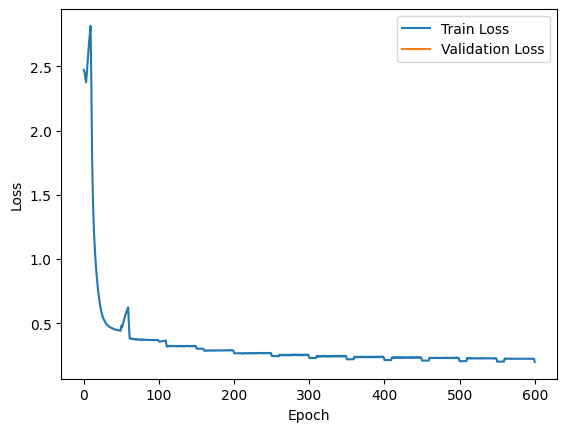

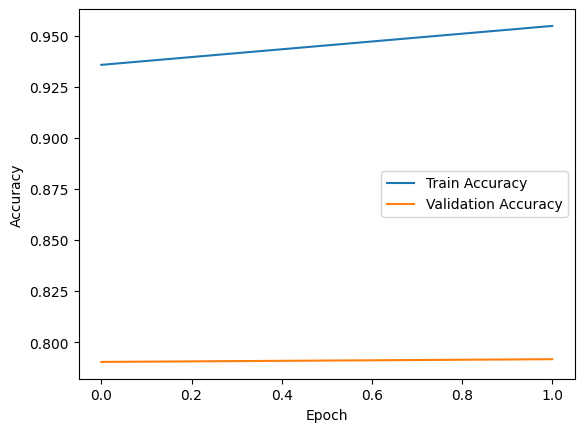

In [8]:
# from gcond_transduct_multi_level import GCond
agent = GCond(data, args, device='cuda:0')

agent.train()

In [3]:
args.reduction_rate = 0.5
agent = GCond(data, args, device='cuda:0')

agent.train()

NameError: name 'args' is not defined

In [1]:
args.reduction_rate = 1
agent = GCond(data, args, device='cuda:0')

agent.train()

NameError: name 'args' is not defined

In [7]:
# 81.2±0.2